# $\texttt{SwiftC}_\ell$ example notebook 

In this notebook we introduce all fo the probes available in \texttt{SwiftC_$\ell$}. To run this notebook please install the following packages: 

- jax-cosmo
- pyccl (with camb)

this will be executed automatically in the next cells.

The first time you run this notebook the gamma coefficints will be automatically computed on your local machine and stored which may take up to 10 minutes - feel free to update the path to where you want this and grab a coffee whilst you wait! This only needs to be done once.

In [1]:
!pip install jax-cosmo
!pip install pyccl
!pip install camb
!pip install pyyaml
!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
from swiftcl.cl import ClComp
import jax

jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
from jax_cosmo import Cosmology, background, transfer
from scipy.constants import speed_of_light

/Users/laura/Documents/ETH/PhD/Projects/SwiftCl_project/env_swiftcl/lib/python3.13/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [3]:
colors = np.array(
    ["#CC6677", "#88CCEE", "#DDCC77", "#882255", "#44AA99", "#999933", "#117733"]
)

In [4]:
# Smail distribution
def smail(z, alpha, beta, z0):
    return (z**alpha / z0 ** (alpha + 1)) * np.exp(-((z / z0) ** beta))


# Parameters
alpha = 4
beta = 6
z0 = 0.7

num_points = 1000
z = np.linspace(0.001, 1.0, num_points)
p_z = smail(
    z, alpha, beta, z0
)  # not necessary to be normalized- UFalcon takes care of this

# Put the redshift distribution in 2D-array form as required by UFalcon code
n = np.zeros((num_points, 2))
n[:, 0] = z
n[:, 1] = p_z

In [5]:
# Cosmological functions from CCL

cosmo_params = {
    "omega_b": 0.0223828,
    "omega_cdm": 0.1201075,
    "h": 0.67810,
    "tau_reio": 0.05430842,
    "n_s": 0.9660499,
    "ln10^{10}A_s": 3.04478,
    "cmin": 2.6,  # minimum halo concentration
    "eta_0": 0.7,  # halo bloating
    "sigma8": 0.8,
}

cosmo_ccl = ccl.Cosmology(
    Omega_c=cosmo_params["omega_cdm"] / cosmo_params["h"] ** 2,
    Omega_b=cosmo_params["omega_b"] / cosmo_params["h"] ** 2,
    h=cosmo_params["h"],
    n_s=cosmo_params["n_s"],
    sigma8=cosmo_params["sigma8"],
)

ll = jnp.unique(jnp.geomspace(6, 2000, 200, dtype="int"))
k = jnp.logspace(-5, 3, num=500)


def Dk_ccl(z, k, cosmo):
    P_nonlin = ccl.power.nonlin_power(cosmo, k, 1 / (1 + z))
    P_nonlin_z0 = ccl.power.nonlin_power(cosmo, k, 1 / 1.5)
    d = np.array([np.sqrt(P_nonlin[i, :] / P_nonlin_z0) for i in range(len(z))])
    return d


chis = ccl.background.comoving_radial_distance(cosmo_ccl, 1 / (1 + n[:, 0]))
H = ccl.background.h_over_h0(cosmo_ccl, 1 / (1 + n[:, 0])) * cosmo_params["h"] * 100
P = ccl.power.nonlin_power(cosmo_ccl, k, 1 / 1.5)
D_c = ccl.background.growth_factor(cosmo_ccl, 1 / (1 + n[:, 0]))
D_k = Dk_ccl(n[:, 0], k, cosmo_ccl)
f = jnp.array(ccl.background.growth_rate(cosmo_ccl, 1 / (1 + n[:, 0])))
A_IA = np.ones((len(n[:, 0]), 2))
A_IA[:, 0] = n[:, 0]
A_IA[:, 1] = np.random.rand(len(n[:, 0]))
A_IA[:, 1] /= np.sum(A_IA[:, 1])


# transfer function for f_NL
cosmo_jax = Cosmology(
    Omega_c=cosmo_params["omega_cdm"] / cosmo_params["h"] ** 2,
    Omega_b=cosmo_params["omega_b"] / cosmo_params["h"] ** 2,
    h=cosmo_params["h"],
    sigma8=cosmo_params["sigma8"],
    n_s=cosmo_params["n_s"],
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0,
)
Tpsi = transfer.Eisenstein_Hu(cosmo_jax, k / cosmo_params["h"])
poisson = (k / cosmo_params["h"] * speed_of_light / 1000) ** 2 / (
    1.5
    * 100.0**2
    * (cosmo_params["omega_cdm"] + cosmo_params["omega_b"])
    / cosmo_params["h"] ** 2
)
z_MD = 11.2
D_zMD = background.growth_factor(cosmo_jax, jnp.array([1 / (1 + z_MD)]))
D_MD = D_c / (D_zMD * (1.0 + z_MD))

Talpha = jnp.einsum("k, c -> ck", Tpsi * poisson, D_MD)


# for CMB lensing
n_CMB_k = np.ones((2000, 2))
n_CMB_k[:, 0] = np.linspace(0, 1100, 2000)

chis_CMB_k = ccl.background.comoving_radial_distance(cosmo_ccl, 1 / (1 + n_CMB_k[:, 0]))
H_CMB_k = (
    ccl.background.h_over_h0(cosmo_ccl, 1 / (1 + n_CMB_k[:, 0]))
    * cosmo_params["h"]
    * 100
)
D_k_CMB_k = Dk_ccl(n_CMB_k[:, 0], k, cosmo_ccl)
f_CMB_k = jnp.array(ccl.background.growth_rate(cosmo_ccl, 1 / (1 + n_CMB_k[:, 0])))

# for CMB ISW
num_points = 1000
z = np.linspace(0.001, 6.0, num_points)
p_z = smail(z, alpha, beta, z0)

n_CMB_T = np.zeros((num_points, 2))
n_CMB_T[:, 0] = z
n_CMB_T[:, 1] = p_z

chis_CMB_T = ccl.background.comoving_radial_distance(cosmo_ccl, 1 / (1 + n_CMB_T[:, 0]))
H_CMB_T = (
    ccl.background.h_over_h0(cosmo_ccl, 1 / (1 + n_CMB_T[:, 0]))
    * cosmo_params["h"]
    * 100
)
D_c_zfid = ccl.background.growth_factor(cosmo_ccl, 1 / 1.5)
D_c_CMB_T = ccl.background.growth_factor(cosmo_ccl, 1 / (1 + n_CMB_T[:, 0])) / D_c_zfid
f_CMB_T = jnp.array(ccl.background.growth_rate(cosmo_ccl, 1 / (1 + n_CMB_T[:, 0])))
D_k_CMB_T = Dk_ccl(n_CMB_T[:, 0], k, cosmo_ccl)

n = jnp.array(n)
n_CMB_T = jnp.array(n_CMB_T)
n_CMB_k = jnp.array(n_CMB_k)

In [6]:
path = "./"  # where to save the gamma coefficients

c_g = ClComp(
    z1=[n[0, 0], n[-1, 0]],
    z2=[n[0, 0], n[-1, 0]],
    contr1="g",
    contr2="g",
    l=ll,
    k=k,
    jit=False,
    path=path,
)
c_g_mag = ClComp(
    z1=[n[0, 0], n[-1, 0]],
    z2=[n[0, 0], n[-1, 0]],
    contr1="g,mag",
    contr2="g,mag",
    l=ll,
    k=k,
    jit=False,
    path=path,
)
c_g_RSD = ClComp(
    z1=[n[0, 0], n[-1, 0]],
    z2=[n[0, 0], n[-1, 0]],
    contr1="g,RSD",
    contr2="g,RSD",
    l=ll,
    k=k,
    jit=False,
    path=path,
)
c_wl = ClComp(
    z1=[n[0, 0], n[-1, 0]],
    z2=[n[0, 0], n[-1, 0]],
    contr1="wl",
    contr2="wl",
    l=ll,
    k=k,
    jit=False,
    path=path,
)
c_CMB_k = ClComp(
    z1=[n_CMB_k[0, 0], n_CMB_k[-1, 0]],
    z2=[n_CMB_k[0, 0], n_CMB_k[-1, 0]],
    contr1="CMB_k",
    contr2="CMB_k",
    l=ll,
    k=k,
    jit=False,
    path=path,
)
c_CMB_T = ClComp(
    z1=[n_CMB_T[0, 0], n_CMB_T[-1, 0]],
    z2=[n_CMB_T[0, 0], n_CMB_T[-1, 0]],
    contr1="CMB_T",
    contr2="g",
    l=ll,
    k=k,
    jit=False,
    path=path,
)
c_fNL = ClComp(
    z1=[n[0, 0], n[-1, 0]],
    z2=[n[0, 0], n[-1, 0]],
    contr1="f_NL",
    contr2="f_NL",
    l=ll,
    k=k,
    jit=False,
    path=path,
)
c_fNL_mod = ClComp(
    z1=[n[0, 0], n[-1, 0]],
    z2=[n[0, 0], n[-1, 0]],
    contr1="f_NL_mod",
    contr2="f_NL_mod",
    l=ll,
    k=k,
    jit=False,
    path=path,
)
c_g_fNL = ClComp(
    z1=[n[0, 0], n[-1, 0]],
    z2=[n[0, 0], n[-1, 0]],
    contr1="g,f_NL",
    contr2="g,f_NL",
    l=ll,
    k=k,
    jit=False,
    path=path,
)

cl_swiftcl_g = c_g.C_l(
    n1=n,
    n2=n,
    chis1=chis,
    chis2=chis,
    D1=D_k,
    D2=D_k,
    P=P,
    H1=H,
    H2=H,
    H0=cosmo_ccl["h"] * 100,
    O_m=cosmo_ccl["Omega_c"] + cosmo_ccl["Omega_b"],
)
cl_swiftcl_g_mag = c_g_mag.C_l(
    n1=n,
    n2=n,
    chis1=chis,
    chis2=chis,
    D1=D_k,
    D2=D_k,
    P=P,
    H1=H,
    H2=H,
    H0=cosmo_ccl["h"] * 100,
    O_m=cosmo_ccl["Omega_c"] + cosmo_ccl["Omega_b"],
    C_g1=5 * 4 - 2,
    C_g2=5 * 4 - 2,
)
cl_swiftcl_g_RSD = c_g_RSD.C_l(
    n1=n,
    n2=n,
    chis1=chis,
    chis2=chis,
    D1=D_k,
    D2=D_k,
    P=P,
    H1=H,
    H2=H,
    H0=cosmo_ccl["h"] * 100,
    O_m=cosmo_ccl["Omega_c"] + cosmo_ccl["Omega_b"],
    f1=f,
    f2=f,
)
cl_swiftcl_wl = c_wl.C_l(
    n1=n,
    n2=n,
    chis1=chis,
    chis2=chis,
    D1=D_k,
    D2=D_k,
    P=P,
    H1=H,
    H2=H,
    H0=cosmo_ccl["h"] * 100,
    O_m=cosmo_ccl["Omega_c"] + cosmo_ccl["Omega_b"],
    A_IA1=A_IA[:, 1],
    A_IA2=A_IA[:, 1],
)
cl_swiftcl_CMB_k = c_CMB_k.C_l(
    n1=n_CMB_k,
    n2=n_CMB_k,
    chis1=chis_CMB_k,
    chis2=chis_CMB_k,
    D1=D_k_CMB_k,
    D2=D_k_CMB_k,
    P=P,
    H1=H_CMB_k,
    H2=H_CMB_k,
    H0=cosmo_ccl["h"] * 100,
    O_m=cosmo_ccl["Omega_c"] + cosmo_ccl["Omega_b"],
    f1=f_CMB_k,
    f2=f_CMB_k,
)
cl_swiftcl_CMB_T = c_CMB_T.C_l(
    n1=n_CMB_T,
    n2=n_CMB_T,
    chis1=chis_CMB_T,
    chis2=chis_CMB_T,
    D1=D_c_CMB_T,
    D2=D_k_CMB_T,
    P=P,
    H1=H_CMB_T,
    H2=H_CMB_T,
    H0=cosmo_ccl["h"] * 100,
    O_m=cosmo_ccl["Omega_c"] + cosmo_ccl["Omega_b"],
    f1=f_CMB_T,
    f2=f_CMB_T,
)
cl_swiftcl_fNL = c_fNL.C_l(
    n1=n,
    n2=n,
    chis1=chis,
    chis2=chis,
    D1=D_k,
    D2=D_k,
    P=P,
    H1=H,
    H2=H,
    H0=cosmo_ccl["h"] * 100,
    O_m=cosmo_ccl["Omega_c"] + cosmo_ccl["Omega_b"],
    b_fNL1=1.0,
    f_NL1=1.0,
    T1=Talpha,
    T2=Talpha,
)
cl_swiftcl_g_fNL = c_g_fNL.C_l(
    n1=n,
    n2=n,
    chis1=chis,
    chis2=chis,
    D1=D_k,
    D2=D_k,
    P=P,
    H1=H,
    H2=H,
    H0=cosmo_ccl["h"] * 100,
    O_m=cosmo_ccl["Omega_c"] + cosmo_ccl["Omega_b"],
    b_fNL1=1.0,
    f_NL1=1.0,
    T1=Talpha,
    T2=Talpha,
)

First initialisation: computing the gamma coefficients, this might take a few minutes...
First initialisation: computing the gamma coefficients, this might take a few minutes...
First initialisation: computing the gamma coefficients, this might take a few minutes...


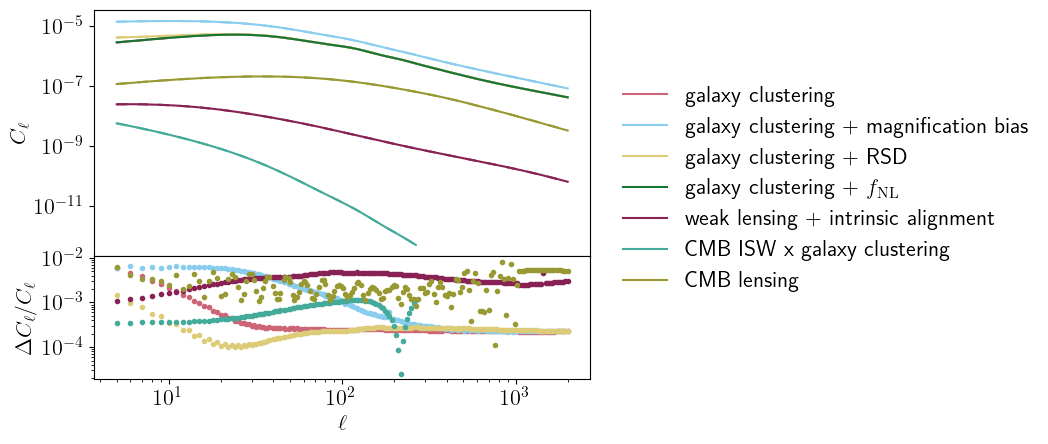

In [ ]:
# single plot

plt.figure()

plt.loglog(ll, cl_swiftcl_g, label="galaxy clustering", color=colors[0])
plt.loglog(
    ll,
    cl_swiftcl_g_mag,
    label="galaxy clustering + magnification bias",
    color=colors[1],
)
plt.loglog(ll, cl_swiftcl_g_RSD, label="galaxy clustering + RSD", color=colors[2])
plt.loglog(
    ll, cl_swiftcl_g_fNL, label=r"galaxy clustering + $f_\mathrm{NL}$", color=colors[6]
)
plt.loglog(
    ll, cl_swiftcl_wl, label="weak lensing + intrinsic alignment", color=colors[3]
)
plt.loglog(
    ll[:100],
    cl_swiftcl_CMB_T[:100],
    label="CMB ISW x galaxy clustering",
    color=colors[4],
)
plt.loglog(ll, cl_swiftcl_CMB_k, label="CMB lensing", color=colors[5])

plt.legend(bbox_to_anchor=(0.92, 0.25), loc="lower left", frameon=False)
plt.ylabel(r"$C_\ell$")
plt.xlabel(r"$\ell$")
plt.show()